In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

from geopy.distance import great_circle
from shapely.geometry import MultiPoint


from shapely.geometry import Point
import pyproj
geod = pyproj.Geod(ellps='WGS84')

from scipy import stats

import seaborn as sns
sns.set_style("whitegrid",{
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    'grid.linestyle': '--'
 })
sns.set_context("paper")


# from dask import dataframe as dd 
# from dask.distributed import Client
# client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='4GB')
                   
    
import os
import glob
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
home1 = pd.read_pickle('home_loc_MOREINFO.pickle')

In [447]:
home_pred = pd.read_pickle('home_pred_jan18.pickle')

Make a geopandas dataframe 

In [4]:
geometry = [Point(xy) for xy in zip(home1.home_lng, home1.home_lat)]
crs = {'init': 'epsg:4326'} 
home2 = gpd.GeoDataFrame(home1, crs=crs, geometry=geometry)

# 0. Read data

## 0.1 Stay locations

In [ ]:
stays2 = pd.read_pickle('stays2.pickle')

In [6]:
stays2['month'] = stays2.stay_beginning.apply(lambda x: x.month)

In [7]:
stay_freq = stays2.groupby(['uid','month']).count().reset_index().groupby('uid').count()
stay_freq_high = stay_freq[stay_freq.month>=2]

## 0.2 Block group data with Predicted Pop

In [800]:
df = pd.read_pickle('home_pred_jan18.pickle')

## 0.3 Get Census
Chicago is state `17` and county `31`. 

### 0.3.1 Get 2018 ACS Tracts

In [9]:
tract_2018 = gpd.read_file('Data/Shapefiles/il_tract_2018/il_tract_2018.shp')
tract_2018= tract_2018[(tract_2018['STATEFP']=='17')&(tract_2018['COUNTYFP']=='031')]

chi_bound = gpd.read_file('Data/Shapefiles/Chicago_boundaries/geo_export_f05488dc-4f9d-49be-81e3-c094992d4c80.shp')
tract_2018 = gpd.sjoin(tract_2018.to_crs(chi_bound.crs),chi_bound,how='inner')
acs18_tract_1 = pd.read_csv('Data/Census/nhgis0101_csv/nhgis0101_ds239_20185_2018_tract.csv',encoding='latin-1').rename(columns={
    'AJWME001':'pop',
    'AJWVE001':'pop_hisp_cat',
    'AJWVE003':'white',
    'AJWVE004':'black',
    'AJWVE006':'asian',
    'AJWVE012':'hispanic',
    'AJYPE022':'ba',
    'AJYPE023':'ma',
    'AJYPE024':'prof',
    'AJYPE025':'phd',
    'AJY9E001':'households',
    'AJY9E003':'10k_15k',
    'AJY9E004':'15k_20k',
    'AJY9E005':'20k_25k',
    'AJY9E006':'25k_30k',
    'AJY9E007':'30k_35k',
    'AJY9E008':'35k_40k',
    'AJY9E009':'40k_45k',
    'AJY9E010':'45k_50k',
    'AJY9E011':'50k_60k',
    'AJY9E012':'60k_75k',
    'AJY9E013':'75k_100k',
    'AJY9E014':'100k_125k',
    'AJY9E015':'125k_150k',
    'AJY9E016':'150k_200k',
    'AJY9E017':'200k_more'  
})[['STATEA','COUNTYA','GISJOIN','pop','pop_hisp_cat','white','black','asian','hispanic','ba','ma','prof',
    'phd','households','10k_15k','15k_20k','20k_25k','25k_30k','30k_35k','35k_40k','40k_45k',
    '45k_50k','50k_60k','60k_75k','75k_100k','100k_125k','125k_150k','150k_200k','200k_more']]


acs18_tract_1 = acs18_tract_1[(acs18_tract_1['pop']>0)&(acs18_tract_1['pop'].isna()==False)]

acs18_tract_1['higher_ed'] = acs18_tract_1['ba']+acs18_tract_1['ma']+acs18_tract_1['prof']+acs18_tract_1['phd']

acs18_tract_1['white_perc'] = acs18_tract_1['white']/acs18_tract_1['pop_hisp_cat']
acs18_tract_1['black_perc'] = acs18_tract_1['black']/acs18_tract_1['pop_hisp_cat']
acs18_tract_1['asian_perc'] = acs18_tract_1['asian']/acs18_tract_1['pop_hisp_cat']
acs18_tract_1['hispanic_perc'] = acs18_tract_1['hispanic']/acs18_tract_1['pop_hisp_cat']
acs18_tract_1['higher_ed_perc'] = acs18_tract_1['higher_ed']/acs18_tract_1['pop_hisp_cat']

acs18_tract = tract_2018.merge(acs18_tract_1,on='GISJOIN',how='left')

### UTM 16 is Illinois zone 
### EPSG is 32616
acs18_tract['Shape_area'] = acs18_tract.to_crs({'init':'epsg:32616'}).area
acs18_tract['pop_dens'] = acs18_tract['pop']/acs18_tract['Shape_area']
acs18_tract = acs18_tract.to_crs({'init':'epsg:4326'})[['GISJOIN', 'Shape_Leng', 'Shape_Area', 'geometry', 'STATEA', 'COUNTYA',
       'pop','pop_dens','pop_hisp_cat', 'white', 'black', 'asian', 'hispanic', 'ba', 'ma', 'prof', 'phd',
      'higher_ed', 'Shape_area','white_perc','black_perc','asian_perc','hispanic_perc','higher_ed_perc',
      '10k_15k','15k_20k','20k_25k','25k_30k','30k_35k','35k_40k','40k_45k',
    '45k_50k','50k_60k','60k_75k','75k_100k','100k_125k','125k_150k','150k_200k','200k_more']]

### 0.3.2 Get 2018 ACS Block Groups

In [10]:
blkgrp_2018= gpd.read_file('Data/Shapefiles/IL_blck_grp_2018/IL_blck_grp_2018.shp')
blkgrp_2018= blkgrp_2018[(blkgrp_2018['STATEFP']=='17')&(blkgrp_2018['COUNTYFP']=='031')]

chi_bound = gpd.read_file('Data/Shapefiles/Chicago_boundaries/geo_export_f05488dc-4f9d-49be-81e3-c094992d4c80.shp')

blkgrp_2018 = gpd.sjoin(blkgrp_2018.to_crs(chi_bound.crs),chi_bound,how='inner')
acs18_blkgrp_1 = pd.read_csv('Data/Census/nhgis0100_csv/nhgis0100_ds239_20185_2018_blck_grp.csv',encoding='latin-1').rename(columns={
    'AJWME001':'pop',
    'AJWVE001':'pop_hisp_cat',
    'AJWVE003':'white',
    'AJWVE004':'black',
    'AJWVE006':'asian',
    'AJWVE012':'hispanic',
    'AJYPE022':'ba',
    'AJYPE023':'ma',
    'AJYPE024':'prof',
    'AJYPE025':'phd',
    'AJY9E001':'households',
    'AJY9E003':'10k_15k',
    'AJY9E004':'15k_20k',
    'AJY9E005':'20k_25k',
    'AJY9E006':'25k_30k',
    'AJY9E007':'30k_35k',
    'AJY9E008':'35k_40k',
    'AJY9E009':'40k_45k',
    'AJY9E010':'45k_50k',
    'AJY9E011':'50k_60k',
    'AJY9E012':'60k_75k',
    'AJY9E013':'75k_100k',
    'AJY9E014':'100k_125k',
    'AJY9E015':'125k_150k',
    'AJY9E016':'150k_200k',
    'AJY9E017':'200k_more',
    'AJZAE001':'median_income'    
})[['STATEA','COUNTYA','GISJOIN','pop','pop_hisp_cat','white','black','asian','hispanic','ba','ma','prof',
    'phd','households','10k_15k','15k_20k','20k_25k','25k_30k','30k_35k','35k_40k','40k_45k',
    '45k_50k','50k_60k','60k_75k','75k_100k','100k_125k','125k_150k','150k_200k','200k_more','median_income']]

acs18_blkgrp_1= acs18_blkgrp_1[(acs18_blkgrp_1['STATEA']==17)&(acs18_blkgrp_1['COUNTYA']==31)]
acs18_blkgrp_1 = acs18_blkgrp_1[(acs18_blkgrp_1['pop']>0)&(acs18_blkgrp_1['pop'].isna()==False)]

acs18_blkgrp_1['higher_ed'] = acs18_blkgrp_1['ba']+acs18_blkgrp_1['ma']+acs18_blkgrp_1['prof']+acs18_blkgrp_1['phd']
acs18_blkgrp_1['white_perc'] = acs18_blkgrp_1['white']/acs18_blkgrp_1['pop_hisp_cat']
acs18_blkgrp_1['black_perc'] = acs18_blkgrp_1['black']/acs18_blkgrp_1['pop_hisp_cat']
acs18_blkgrp_1['asian_perc'] = acs18_blkgrp_1['asian']/acs18_blkgrp_1['pop_hisp_cat']
acs18_blkgrp_1['hispanic_perc'] = acs18_blkgrp_1['hispanic']/acs18_blkgrp_1['pop_hisp_cat']
acs18_blkgrp_1['higher_ed_perc'] = acs18_blkgrp_1['higher_ed']/acs18_blkgrp_1['pop_hisp_cat']

acs18_blkgrp = blkgrp_2018.merge(acs18_blkgrp_1,on='GISJOIN',how='left')

### UTM 16 is Illinois zone 
### EPSG is 32616
acs18_blkgrp['Shape_area'] = acs18_blkgrp.to_crs({'init':'epsg:32616'}).area
acs18_blkgrp['pop_dens'] = acs18_blkgrp['pop']/acs18_blkgrp['Shape_area']

acs18_blkgrp = acs18_blkgrp.to_crs({'init':'epsg:4326'})[['GISJOIN', 'Shape_Leng', 'Shape_Area', 'geometry', 'STATEA', 'COUNTYA',
       'pop','pop_dens','pop_hisp_cat', 'white', 'black', 'asian', 'hispanic', 'ba', 'ma', 'prof', 'phd',
      'higher_ed', 'Shape_area','white_perc','black_perc','asian_perc','hispanic_perc','higher_ed_perc',
      '10k_15k','15k_20k','20k_25k','25k_30k','30k_35k','35k_40k','40k_45k',
    '45k_50k','50k_60k','60k_75k','75k_100k','100k_125k','125k_150k','150k_200k','200k_more','median_income']]

# 1. Compare cell diversity to neighorhood diversity

Questons to answer:
- Can we measure the tract level experienced diversity measure?
- How does the experienced diversity measure change with the sample size and do we want this? 
- Consider using the weights to adjust for how many people user is suppose to represent? Or perhaps just use the regression. 

In [801]:
pop_blkgrp_using = df[[ 'GISJOIN','pop', 'cell_pop','white', 'black', 'asian', 'hispanic', 'ba', 'ma', 'prof', 'phd',
       'median_income', 'higher_ed', 'Shape_area','white_perc','black_perc','asian_perc','hispanic_perc','higher_ed_perc','weights','predicted_pop']]

## 1.1 Join the stays to home demographics and blk grp of the stay

In [12]:
home_acs = gpd.sjoin(home2,acs18_blkgrp[['geometry','GISJOIN']])

In [46]:
# stays3 = gpd.GeoDataFrame(stays2,geometry = gpd.points_from_xy(stays2.stay_lng,stays2.stay_lat),crs={'init':'epsg:4326'})

# ### Join stays to their home block group with demographics
stays4 = stays2.merge(gpd.sjoin(home2[['uid','home_lng','home_lat','geometry']],
                                df[['geometry','GISJOIN','white_perc', 'black_perc','asian_perc', 
                                    'hispanic_perc','pop','predicted_pop','weights']]).rename(columns={'GISJOIN':"GISJOIN_home"}),on='uid')
stays4 = gpd.GeoDataFrame(stays4, geometry='geometry_x',crs={'init':'epsg:4326'}).drop(columns=['geometry_y','index_right']).rename(columns={'geometry_x':'geometry'})

# ### Join stays to their current block group
stays5 = gpd.sjoin(stays4,acs18_blkgrp[['GISJOIN','geometry']].rename(columns={'GISJOIN':"GISJOIN_stay"}))
# stay6 = stays5[stays5.GISJOIN_home.isna()==False]

## 1.2 For each tract, we want to find the non-resi exposure measure

In [900]:
def get_exposure(GISJOIN_stay):
    d = stays5[stays5['GISJOIN_stay']==GISJOIN_stay][['white_perc', 'black_perc',
       'asian_perc', 'hispanic_perc','weights']]

    try: 
        new_prop = np.average(d[['white_perc', 'black_perc','asian_perc', 'hispanic_perc',]],
                          weights=d['weights'],axis=0)/np.average(d[['white_perc', 'black_perc','asian_perc', 'hispanic_perc',]],
                                                                    weights=d['weights'],axis=0).sum()
        exp = (new_prop*(new_prop.sum()-new_prop)).sum()
    except ZeroDivisionError: 
        exp= 0 
    return exp

def get_exposure_acs(d):
    '''
    Calculates the Simpson Index
    '''
    ### Calculates the p_a*sum(p_b) where b!=a
    new_prop =d.values/d.sum(axis=1).values
    exp = (new_prop*(new_prop.sum()-new_prop)).sum()
    return exp



## 1.3 Find the ACS exposure

In [802]:
df['blkgrp_exp'] = df.apply(lambda x: get_exposure_acs(pd.DataFrame({'white_perc':x['white_perc'],
                                         'black_perc':x['black_perc'],
                                         'asian_perc':x['asian_perc'],
                                         'hispanic_perc':x['hispanic_perc']},index=[0])),axis=1)

## 1.4 Find the cell phone data cluster exposure
To do this, for each block group in the ACS, I need to calculate the weighted average of percentages 

In [803]:
df['cell_exp'] = df['GISJOIN'].apply(lambda x: get_exposure(x))
df['cell_exp'] = df['cell_exp'].fillna(0)

In [804]:
df['cell_exp_more'] = df['cell_exp']/(df['blkgrp_exp']+.0000001)
df['more'] =df['cell_exp_more'].apply(lambda x: 'More' if x >1 else "Less")

## 1.5 Get Correlations

In [805]:
from scipy.stats import spearmanr
print(np.corrcoef(df['cell_exp'],df['blkgrp_exp']))
print(spearmanr(df['cell_exp'],df['blkgrp_exp']))


[[1.         0.80714043]
 [0.80714043 1.        ]]
SpearmanrResult(correlation=0.8149110581930559, pvalue=0.0)


## 1.6 Maps

(-87.8874961400547, -87.50686331680319, 41.62534351582253, 42.042077540192686)

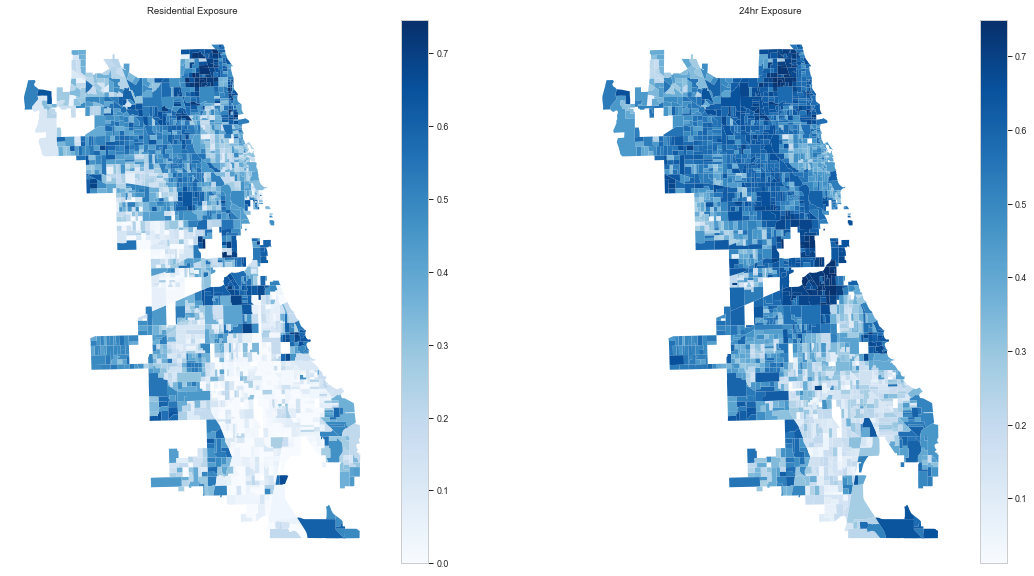

In [806]:
fig, ax = plt.subplots(1,2,figsize=(19,10))
df.plot(column='cell_exp', 
           cmap='Blues',
           ax=ax[1],
#            scheme='equal_interval',
           edgecolor='none',
           legend=True)
ax[1].set_title('24hr Exposure')
ax[1].axis('off')

df.plot(column='blkgrp_exp',
           cmap='Blues', 
           ax=ax[0],
#            scheme='equal_interval',
           edgecolor='none',
           legend=True)
ax[0].set_title('Residential Exposure')
ax[0].axis('off')
# fig.savefig('Using/Images/exposure_comparison_map.png')



## 1.7 Block Groups with less than residential exposure

(-87.88749759793764, -87.50683270126099, 41.62534351582253, 42.042077540192686)

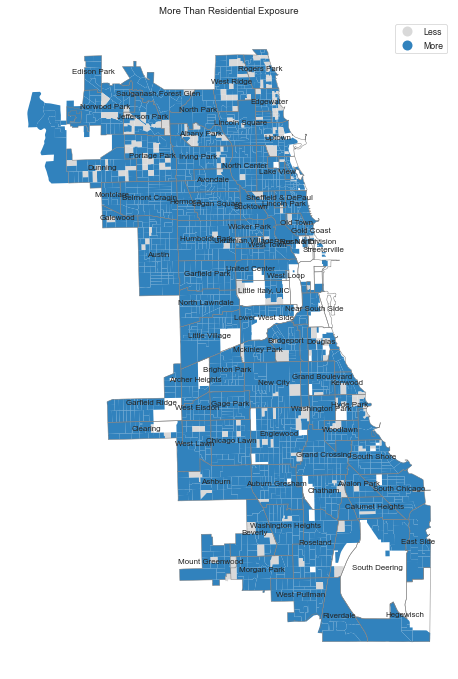

In [808]:
neigh = gpd.read_file('Data/Shapefiles/chicago_neighborhoods/Neighborhoods_2012b.shp').to_crs({'init':'epsg:4326'})
neigh_less=gpd.sjoin(neigh,df,how='inner',op='contains')\
              .groupby('PRI_NEIGH')\
              .first()\
              .reset_index()

fig, ax = plt.subplots(1,1,figsize=(20,12))
base = df.plot(column='more',
          cmap='tab20c_r',
#         scheme='quantiles',
          ax=ax,
          edgecolor='none',
         legend=True)
neigh.geometry.boundary.plot(ax=base,color=None, edgecolor='gray',linewidth=0.5,)
for idx, row in neigh_less.iterrows():
    plt.annotate(s=row['PRI_NEIGH'], xy=[row.geometry.centroid.x,row.geometry.centroid.y],
                 horizontalalignment='center',fontsize=8)
ax.set_title('More Than Residential Exposure')
ax.axis('off')
# fig.savefig('Using/Images/less_resi_exposure.png')



# 2. Analyze Clusters

In [1084]:
import datetime

### Tighter clustering for stays
def cluster_space(partition,rad=0.03,lat='stay_lat',lng='stay_lng'):
    coords = partition[[lat,lng]].values
    kms_per_radian = 6371.0088
    epsilon = rad / kms_per_radian ## about 30 ft
    db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    partition['space_label'] = cluster_labels
    return partition['space_label']

def cluster_time(partition):
    time = partition[['datetime']].apply(lambda x: (x- datetime.datetime(1970,1,1)).dt.total_seconds() )
    epsilon_t = 300 ## ten minute max time diff
    
    db_t = DBSCAN(eps=epsilon_t, min_samples=2).fit(time)
    cluster_labels_t = db_t.labels_
    num_clusters_t = len(set(cluster_labels_t))
    clusters_t = pd.Series([time[cluster_labels_t == n] for n in range(num_clusters_t)])
    partition['time_label'] = cluster_labels_t
    return partition['time_label']


def get_cluster_space(partition,rad=0.03):
    df = partition.groupby(['date']).apply(lambda x: cluster_space(x,rad)).reset_index()
    return df

def get_cluster_space_time(partition):
    df = partition.groupby(['date','space_label']).apply(cluster_time).reset_index()
    return df

## 2.1 Cluster by space

Cluster stays by space first and join these back to main list of all stays. 

In [1085]:
stays_c = pd.merge(stays5,get_cluster_space(stays5,0.03).set_index('level_1'),left_index=True,right_index=True)
stays_c1 = stays_c.drop(columns=['date_y']).rename(columns={'date_x':'date'})

stays_c1 = gpd.GeoDataFrame(stays_c1,geometry='geometry')

## 2.2 Then cluster by time given space constraint

In [1086]:
stays_c1['datetime'] = pd.to_datetime(stays_c1['date'].apply(lambda x: x[:8]))

In [1087]:
stays_c2 =pd.merge(stays_c1, get_cluster_space_time(stays_c1[stays_c1['space_label']>=0]).set_index('level_2'),left_index=True,right_index=True)
stays_c3= stays_c2.drop(columns=['date_y','space_label_y']).rename(columns={'date_x':'date','space_label_x':'space_label'})

## 2.3 Find all the unique interaction space-time volumes

In [1088]:
stays_c3['unique_interactions_30ft'] = stays_c3.apply(lambda x: '{}_{}_{}'.format(x['date'],x['space_label'],x['time_label']),axis=1)

### 2.3.1 Keep only the clusters and find counts within each cluster. 
Filtering just for those unique stays in a cluster. 

In [1645]:
stays_c3 = pd.read_pickle('stays_clustered_10m.pickle')

In [1373]:
unique_ppl_stays = stays_c3[stays_c3.time_label>=0].groupby(['unique_interactions_10ft'])['uid'].unique()
unique_ppl_stays = pd.DataFrame(unique_ppl_stays).reset_index()
unique_ppl_stays['count'] = unique_ppl_stays.apply(lambda x: len(x['uid']),axis=1)

In [1646]:
# unique_ppl_stays.to_pickle('unique_stays_clustered_20m.pickle')
unique_ppl_stays = pd.read_pickle('unique_stays_clustered_10m.pickle')

In [1410]:
# test = pd.merge(home_acs,home_pred[['GISJOIN','weights']],on='GISJOIN')

### 2.3.2 Find the clusters with at least two people. 

In [1502]:
ppl_in_interactions = stays_c3[stays_c3['unique_interactions_30ft'].isin(unique_ppl_stays[unique_ppl_stays['count']>1]['unique_interactions_30ft'])]\
            .sort_values('unique_interactions_30ft')

ppl_in_interactions = ppl_in_interactions.groupby(['unique_interactions_30ft','uid']).first().reset_index()
ppl_in_interactions['month'] = ppl_in_interactions['stay_beginning'].dt.month
ppl_in_interactions['hour'] = ppl_in_interactions['stay_beginning'].dt.hour
ppl_in_interactions['day_of_week'] = ppl_in_interactions['stay_beginning'].dt.dayofweek

def time_day(hr): 
    if (hr>0)&(hr<7):
        return 'Early Morning'
    elif (hr>=7)&(hr<12): 
        return "Morning"
    elif (12>=7)&(hr<16): 
        return "Afternoon"
    else: 
        return "Evening"
    
ppl_in_interactions['time_of_day'] = ppl_in_interactions['hour'].apply(lambda x:time_day(x) )

In [1412]:
# final_social_interactions = pd.read_csv( 'Using/Data/final_social_interactions.csv')

## 2.4 Get the unique stays of people in clusters as well as those. 

In [1463]:
stays_c3.groupby('unique_interactions_20ft').count()['uid'].describe()

count    218460.000000
mean          4.126531
std           3.938589
min           2.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         208.000000
Name: uid, dtype: float64

In [1503]:
ppl_in_interactions = ppl_in_interactions.sort_values('unique_interactions_30ft')

In [1519]:
ppl_in_interactions_evening = ppl_in_interactions[(ppl_in_interactions['hour']>=17)&(ppl_in_interactions['hour']<24)]
ppl_in_interactions_day = ppl_in_interactions[(ppl_in_interactions['hour']>=9)&(ppl_in_interactions['hour']<17)]
ppl_in_interactions_morning = ppl_in_interactions[(ppl_in_interactions['hour']>=5)&(ppl_in_interactions['hour']<9)]

In [1486]:
print("The number of people in interactions are {}".format(ppl_in_interactions.shape[0]))

The number of people in interactions are 87995


## 2.5 Get the list of unique interactions

In [1520]:
# uniq_iter= ppl_in_interactions.groupby(['unique_interactions_30ft']).first().reset_index()
uniq_iter_morning= ppl_in_interactions_morning.groupby(['unique_interactions_30ft']).first().reset_index()
uniq_iter_day= ppl_in_interactions_day.groupby(['unique_interactions_30ft']).first().reset_index()
uniq_iter_evening= ppl_in_interactions_evening.groupby(['unique_interactions_30ft']).first().reset_index()


Number of people within all unique interactions. 

## 2.6 Calculate the stay cluster exposures

In [1526]:
def get_exposure2(unique_interactions):
    d = ppl_in_interactions_evening[ppl_in_interactions_evening['unique_interactions_30ft']==unique_interactions][['uid','unique_interactions_30ft','white_perc', 'black_perc',
       'asian_perc', 'hispanic_perc','weights']]
    new_prop = np.average(d[['white_perc', 'black_perc','asian_perc', 'hispanic_perc',]],weights=d['weights'],axis=0)/np.average(d[['white_perc', 'black_perc','asian_perc', 'hispanic_perc',]],weights=d['weights'],axis=0).sum()
    exp = (new_prop*(new_prop.sum()-new_prop)).sum()
    return exp

This should take about 20 minutes 

In [1490]:
print(datetime.datetime.now())
uniq_iter['inter_exp'] = uniq_iter['unique_interactions_30ft'].apply(lambda x: get_exposure2(x))
print(datetime.datetime.now())


2021-01-30 22:16:22.673430
2021-01-30 22:23:22.298906


In [1523]:
print(datetime.datetime.now())
uniq_iter_morning['inter_exp'] = uniq_iter_morning['unique_interactions_30ft'].apply(lambda x: get_exposure2(x))
print(datetime.datetime.now())


2021-01-30 22:42:39.859053
2021-01-30 22:43:23.216654


In [1525]:
print(datetime.datetime.now())
uniq_iter_day['inter_exp'] = uniq_iter_day['unique_interactions_30ft'].apply(lambda x: get_exposure2(x))
print(datetime.datetime.now())


2021-01-30 22:43:29.731380
2021-01-30 22:48:39.257807


In [1528]:
print(datetime.datetime.now())
uniq_iter_evening['inter_exp'] = uniq_iter_evening['unique_interactions_30ft'].apply(lambda x: get_exposure2(x))
print(datetime.datetime.now())


2021-01-30 22:49:44.613165
2021-01-30 22:51:49.320692


### Start here

In [1500]:
# uniq_iter.to_pickle('uniq_iter_30m.pickle')
uniq_iter = pd.read_pickle('uniq_iter_30m.pickle')

Join the score of each cluster back to individual stays, so that each stay has a score. 

In [1533]:
# ppl_in_interactions = pd.merge(ppl_in_interactions,uniq_iter[['unique_interactions_30ft','inter_exp']],on='unique_interactions_30ft')
stays7_morning = pd.merge(stays_c3,uniq_iter_morning[['unique_interactions_30ft','inter_exp']],on='unique_interactions_30ft')
stays7_day = pd.merge(stays_c3,uniq_iter_day[['unique_interactions_30ft','inter_exp']],on='unique_interactions_30ft')
stays7_evening = pd.merge(stays_c3,uniq_iter_evening[['unique_interactions_30ft','inter_exp']],on='unique_interactions_30ft')

## 2.7 See how interactions change over hour and day of week

In [1609]:
uniq_iter['day_of_week_hr'] = uniq_iter.apply(lambda x: x['hour']+(24*x['day_of_week']),axis=1)

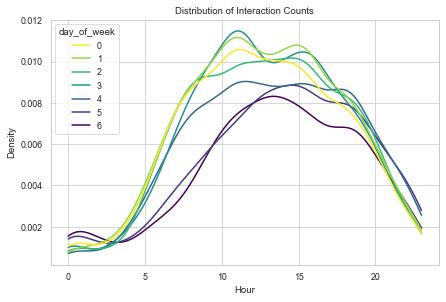

In [1495]:
plt.figure(figsize=[6,4])
sns.kdeplot(data=uniq_iter[uniq_iter['month']!=6],x='hour',hue='day_of_week',label='Cell',cut=0,bw=0.2,lw=1.5,palette="viridis_r")
plt.xlabel('Hour')
plt.title("Distribution of Interaction Counts")
plt.tight_layout(pad=0)
# plt.savefig('Using/Images/interactions_hour_dist.png')

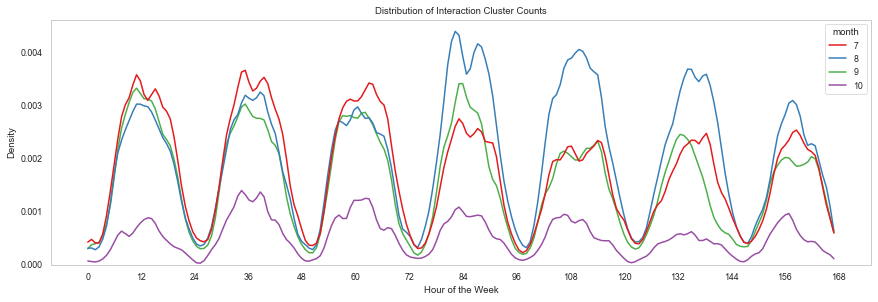

In [1611]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,1,figsize=(12,4))

sns.kdeplot(data=uniq_iter[uniq_iter['month']!=6],x='day_of_week_hr',ax=ax,hue='month',label='Cell',cut=0,bw=0.02,lw=1.5,palette="Set1")
ax.set_xlabel('Hour of the Week')
ax.grid(False)
ax.set_title("Distribution of Interaction Cluster Counts")
# ax.set_xticks(np.tile(np.arange(0,24),7))
ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
# ax.set_xticklabels(np.tile(np.arange(0,24,12),8))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.tight_layout(pad=0)
plt.savefig('Using/Images/interactions_hour_week_dist.png')

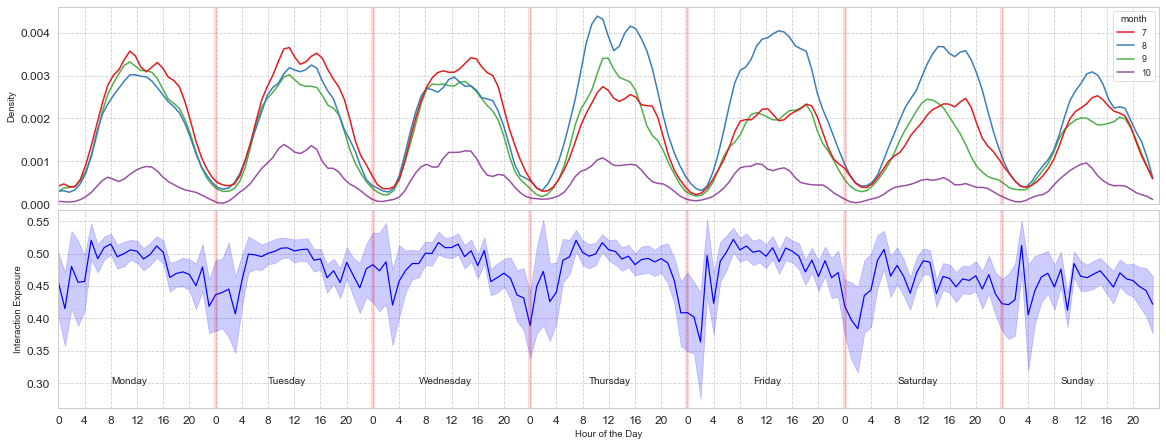

In [1663]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(2,1,figsize=(16,6),sharex=True)

vline_style =dict(color='red',alpha=.15,linestyle='-',lw=4)
text_style = dict(size=10, color='gray')
text_pos = .3

sns.kdeplot(data=uniq_iter[uniq_iter['month']!=6],x='day_of_week_hr',ax=ax[0],hue='month',label='Cell',cut=0,bw=0.02,lw=1.5,palette="Set1")
ax[0].set_xlabel('Hour of the Week')
ax[0].axvline(24, **vline_style)
ax[0].axvline(48, **vline_style)
ax[0].axvline(72, **vline_style)
ax[0].axvline(96, **vline_style)
ax[0].axvline(120,**vline_style)
ax[0].axvline(144,**vline_style)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(4))
ax[0].set_xticklabels(np.insert(np.tile(np.arange(0,24,4),7),0,[0]))
ax[0].tick_params(axis='both', which='major', labelsize=12)



sns.lineplot(data=uniq_iter,x='day_of_week_hr',y='inter_exp',ax=ax[1],color='Blue')

ax[1].axvline(24, **vline_style)
ax[1].axvline(48, **vline_style)
ax[1].axvline(72, **vline_style)
ax[1].axvline(96, **vline_style)
ax[1].axvline(120,**vline_style)
ax[1].axvline(144,**vline_style)
ax[1].text( 8,text_pos,'Monday')
ax[1].text( 32,text_pos,'Tuesday')    
ax[1].text( 55,text_pos,'Wednesday')   
ax[1].text( 81,text_pos,'Thursday')   
ax[1].text( 106,text_pos,'Friday')   
ax[1].text( 128,text_pos,'Saturday')
ax[1].text( 153,text_pos,'Sunday')   

ax[1].set_xlabel('Hour of the Day')
ax[1].set_ylabel('Interaction Exposure')

# ax.grid(False)
#     ax[counter].set_title("Distribution of Interaction Exposure")
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(4))
ax[1].set_xticklabels(np.insert(np.tile(np.arange(0,24,4),7),0,[0]))
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlim([0,168])
counter +=1

plt.tight_layout(pad=0)
plt.savefig('Using/Images/interactions_hour_week_plot.png')

## 2.7 Calculate the final weighted average of the exposure measure

Calculated the population weighted interaction exposure

In [1538]:
def weighted_avg(gisjoin): 
    d = stays7_evening[stays7_evening.GISJOIN_stay ==gisjoin]
    if d.shape[0]==0:
        wavg= 0 
    else: 
        wavg = np.average(d['inter_exp'],weights=d['weights'],axis=0)
   
    return wavg

In [1534]:
df_morning = df[df.GISJOIN.isin(stays7_morning.GISJOIN_stay)]
df_day = df[df.GISJOIN.isin(stays7_day.GISJOIN_stay)]
df_evening = df[df.GISJOIN.isin(stays7_evening.GISJOIN_stay)]

In [1506]:
df['weighted_interaction_exposure'] = df['GISJOIN'].apply(lambda x: weighted_avg(x))

In [1507]:
df.to_pickle('df_30m.pickle')

Create a column for counts of ppl in interaction clusters

In [1508]:
df1 = pd.merge(df,final_social_interactions_unique.groupby('GISJOIN_stay').count()['uid'].reset_index().rename(columns={'uid':'count_ppl',"GISJOIN_stay":'GISJOIN'}),on='GISJOIN', how='left').fillna(0)

# 3. Final Table

## 3.1 Residential Summary Statistics

In [1451]:
df1['blkgrp_exp'].describe()

count    2103.000000
mean        0.322525
std         0.214010
min         0.000000
25%         0.128813
50%         0.331415
75%         0.506642
max         0.746061
Name: blkgrp_exp, dtype: float64

## 3.2 Stay Summary Statistics

In [1478]:
df1[df1['cell_exp']!=0]['cell_exp'].describe()


count    2103.000000
mean        0.453811
std         0.173917
min         0.011552
25%         0.328373
50%         0.486726
75%         0.593879
max         0.749610
Name: cell_exp, dtype: float64

In [1479]:
print(np.corrcoef(df1[df1['cell_exp']!=0]['cell_exp'],df1[df1['cell_exp']!=0]['blkgrp_exp']))

[[1.         0.80714043]
 [0.80714043 1.        ]]


## 3.3 Interaction Summary Statistics

10 meter, all times

In [1509]:
df1[df1['weighted_interaction_exposure']!=0]['weighted_interaction_exposure'].describe()

count    1693.000000
mean        0.399899
std         0.173648
min         0.000444
25%         0.279830
50%         0.433176
75%         0.536461
max         0.731441
Name: weighted_interaction_exposure, dtype: float64

In [1510]:
print(np.corrcoef(df1[df1['weighted_interaction_exposure']!=0]['weighted_interaction_exposure'],df1[df1['weighted_interaction_exposure']!=0]['blkgrp_exp']))

[[1.         0.72037277]
 [0.72037277 1.        ]]


In [1540]:
df_morning[df_morning['weighted_interaction_exposure']!=0]['weighted_interaction_exposure'].describe()

count    1063.000000
mean        0.409952
std         0.163796
min         0.000444
25%         0.311487
50%         0.445676
75%         0.535901
max         0.715422
Name: weighted_interaction_exposure, dtype: float64

In [1542]:
print(np.corrcoef(df_morning[df_morning['weighted_interaction_exposure']!=0]['weighted_interaction_exposure'],
                  df_morning[df_morning['weighted_interaction_exposure']!=0]['blkgrp_exp']))

[[1.         0.74071326]
 [0.74071326 1.        ]]


In [1543]:
df_day[df_day['weighted_interaction_exposure']!=0]['weighted_interaction_exposure'].describe()

count    1476.000000
mean        0.368310
std         0.176127
min         0.000959
25%         0.236192
50%         0.390573
75%         0.504382
max         0.746061
Name: weighted_interaction_exposure, dtype: float64

In [1544]:
print(np.corrcoef(df_day[df_day['weighted_interaction_exposure']!=0]['weighted_interaction_exposure'],
                  df_day[df_day['weighted_interaction_exposure']!=0]['blkgrp_exp']))

[[1.         0.66047456]
 [0.66047456 1.        ]]


In [1545]:
df_evening[df_evening['weighted_interaction_exposure']!=0]['weighted_interaction_exposure'].describe()

count    1431.000000
mean        0.351954
std         0.180127
min         0.001810
25%         0.206687
50%         0.369537
75%         0.493102
max         0.746061
Name: weighted_interaction_exposure, dtype: float64

In [1546]:
print(np.corrcoef(df_evening[df_evening['weighted_interaction_exposure']!=0]['weighted_interaction_exposure'],
                  df_evening[df_evening['weighted_interaction_exposure']!=0]['blkgrp_exp']))

[[1.         0.68436343]
 [0.68436343 1.        ]]


## 3.4 Maps of Results

Column for difference in actual interaction exporsure vs block group exposure

In [1511]:
df1['int_diff'] = df1['weighted_interaction_exposure'] - df1['blkgrp_exp']
df1['all_stay_diff'] = df1['cell_exp'] - df1['blkgrp_exp']

In [1549]:
df_morning['int_diff'] = df_morning['weighted_interaction_exposure'] - df_morning['blkgrp_exp']
df_day['int_diff'] = df_day['weighted_interaction_exposure'] - df_day['blkgrp_exp']
df_evening['int_diff'] = df_evening['weighted_interaction_exposure'] - df_evening['blkgrp_exp']

Text(0.5, 1.0, 'Distribution of Residentia and Social Interaction Exposure')

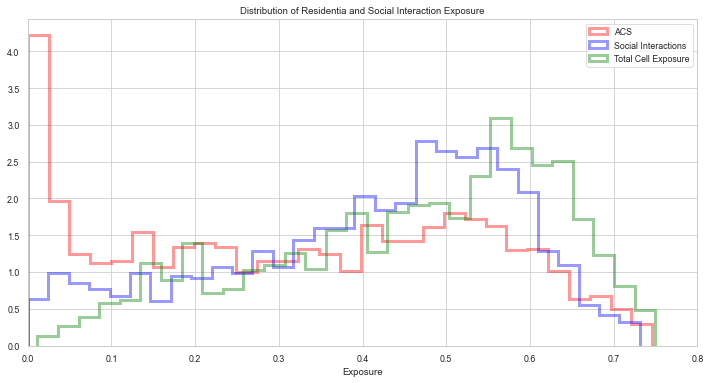

In [1132]:
lw=3

wm = lambda x: np.average(x, weights=uniq_iter["weights"],axis=0)


fig, ax = plt.subplots(1,1,figsize=(12,6))
sns.distplot(df1['blkgrp_exp'],bins=30,ax=ax,color='red',label='ACS',norm_hist=True, kde=False, hist_kws={"histtype": "step",
                                                                                                                             "linewidth": lw})
sns.distplot(df1[df1["weighted_interaction_exposure"]!=0]['weighted_interaction_exposure'],bins=30,ax=ax,color='blue',label='Social Interactions',norm_hist=True, kde=False, hist_kws={"histtype": "step",
                                                                                                                             "linewidth": lw})
sns.distplot(df1[df1["cell_exp"]!=0]['cell_exp'],bins=30,ax=ax,color='green',label='Total Cell Exposure',norm_hist=True, kde=False, hist_kws={"histtype": "step",
                                                                                                                             "linewidth": lw})

plt.xlim([0,.8])

plt.xlabel('Exposure')
plt.legend()
plt.title('Distribution of Residentia and Social Interaction Exposure')
# plt.savefig('Using/Images/exposure_socialint_distribution.png')

In [1322]:
print(np.corrcoef(df1[df1.weighted_interaction_exposure!=0]['weighted_interaction_exposure'],df1[df1.weighted_interaction_exposure!=0]['blkgrp_exp']))

print(np.corrcoef(df1[df1.weighted_interaction_exposure!=0]['weighted_interaction_exposure'],df1[df1.weighted_interaction_exposure!=0]['exp_diff']))


[[1.         0.61826055]
 [0.61826055 1.        ]]
[[1.         0.01004086]
 [0.01004086 1.        ]]


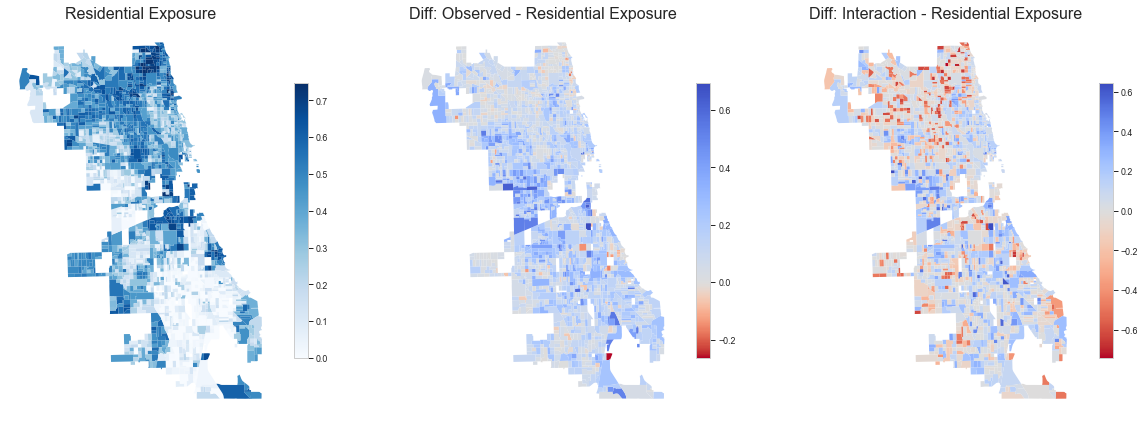

In [1556]:
fig, ax = plt.subplots(1,3,figsize=(17,6))

from matplotlib.colors import TwoSlopeNorm
cmap = 'coolwarm_r'
fontsize = 16
shrinksize = 0.7


df1.plot(column='blkgrp_exp',
           cmap='Blues', 
           ax=ax[0],
#            scheme='quantiles',
           edgecolor='none',
           legend=True,legend_kwds={'shrink':shrinksize})

ax[0].axis('off') 
ax[0].set_title('Residential Exposure', fontdict={'fontsize': fontsize, 'fontweight': 'medium'})

vmin1, vmax1, vcenter1 = df1.all_stay_diff.min(),  df1.all_stay_diff.max(), 0
norm1 = TwoSlopeNorm(vmin=vmin1, vcenter=vcenter1, vmax=vmax1)
# create a normalized colorbar
# cbar = plt.cm.ScalarMappable(norm=norm1, cmap=cmap)

df1.plot(column='all_stay_diff',
           cmap=cmap, 
           ax=ax[1],
           edgecolor='none',
           norm=norm1,
           legend=True,legend_kwds={'shrink':shrinksize})
ax[1].axis('off')
ax[1].set_title('Diff: Observed - Residential Exposure', fontdict={'fontsize': fontsize, 'fontweight': 'medium'})


vmin2, vmax2, vcenter2 = df1.int_diff.min(),  df1.int_diff.max(), 0
norm2 = TwoSlopeNorm(vmin=vmin2, vcenter=vcenter2, vmax=vmax2)

df1.plot(column='int_diff',
           cmap=cmap, 
           ax=ax[2],
           edgecolor='none',
         norm = norm2,
           legend=True,legend_kwds={'shrink':shrinksize})
ax[2].axis('off')
ax[2].set_title('Diff: Interaction - Residential Exposure', fontdict={'fontsize': fontsize, 'fontweight': 'medium'})
fig.tight_layout()
fig.savefig('Using/Images/acs_cell_exposure_diff_map_30m_jan29.png')